In [18]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

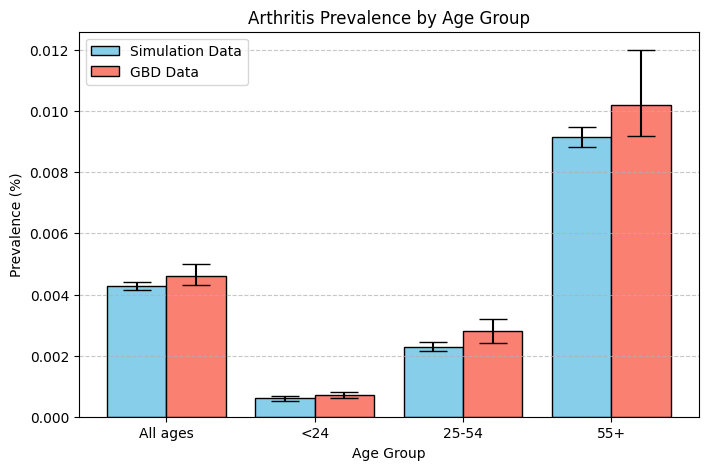

In [16]:
#Load CSV
df = pd.read_csv("Results3.csv")
# Original data
df_subset = df.iloc[1:5]
x_labels = ['All ages', '<24', '25-54', '55+']
x_pos = np.arange(len(df_subset))

yerr_lower = df_subset['mean'] - df_subset['lower']
yerr_upper = df_subset['upper'] - df_subset['mean']
yerr = [yerr_lower, yerr_upper]

# New data to overlay
overlay_values = [0.0046, 0.0007, 0.0028, 0.0102]
overlay_err_lower = [0.0043, 0.0006, 0.0024, 0.0092]
overlay_err_upper = [0.005, 0.0008, 0.0032, 0.012]
overlay_yerr = [np.array(overlay_values) - np.array(overlay_err_lower),
                np.array(overlay_err_upper) - np.array(overlay_values)]

plt.figure(figsize=(8,5))

# Original bars
plt.bar(
    x_pos,
    df_subset['mean'],
    yerr=yerr,
    capsize=10,
    color='skyblue',
    edgecolor='black',
    width=0.4,
    label='Simulation Data'
)

# Overlay bars slightly shifted
plt.bar(
    x_pos + 0.4,  # shift right
    overlay_values,
    yerr=overlay_yerr,
    capsize=10,
    color='salmon',
    edgecolor='black',
    width=0.4,
    label='GBD Data'
)

plt.xticks(x_pos + 0.2, x_labels)  # center tick labels between the groups
plt.xlabel("Age Group")
plt.ylabel("Prevalence (%)")
plt.title("Arthritis Prevalence by Age Group")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend()

plt.savefig("arthritis_prevalence_comparison.png", dpi=300)
plt.show()

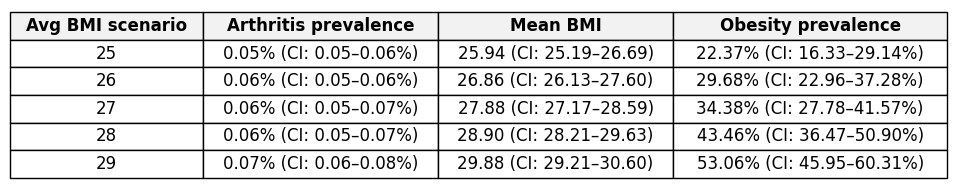

In [19]:
csv_files = {
    25: "Results1.csv",
    26: "Results2.csv",
    27: "Results3.csv",
    28: "Results4.csv",
    29: "Results5.csv",
}

rows = []

for bmi, file in csv_files.items():
    df = pd.read_csv(file)
    df.columns = df.columns.str.strip()

    # Pick rows by absolute index
    ra = df.iloc[2] # RA prevalence <25
    mean_bmi = df.iloc[6] # Mean BMI <25
    obesity = df.iloc[10] # Obesity prevalence <25

    rows.append({
        "Avg BMI scenario": bmi,
        "Arthritis prevalence": (
            f"{ra['mean']*100:.2f}% "
            f"(CI: {ra['lower']*100:.2f}–{ra['upper']*100:.2f}%)"
        ),
        "Mean BMI": (
            f"{mean_bmi['mean']:.2f} "
            f"(CI: {mean_bmi['lower']:.2f}–{mean_bmi['upper']:.2f})"
        ),
        "Obesity prevalence": (
            f"{obesity['mean']*100:.2f}% "
            f"(CI: {obesity['lower']*100:.2f}–{obesity['upper']*100:.2f}%)"
        ),
    })

young_summary = pd.DataFrame(rows)

# Prepare the data for the table
columns = ["Avg BMI scenario", "Arthritis prevalence", "Mean BMI", "Obesity prevalence"]
table_data = young_summary[columns].values.tolist()

fig, ax = plt.subplots(figsize=(10, 2))

# Hide axes
ax.axis('tight')
ax.axis('off')

# Create table
table = ax.table(
    cellText=table_data,
    colLabels=columns,
    cellLoc='center',
    colLoc='center',
    loc='center'
)

# Style the table
table.auto_set_font_size(False)
table.set_fontsize(12)
table.auto_set_column_width(col=list(range(len(columns))))
table.scale(1, 1.5)

# Header styling
for (i, j), cell in table.get_celld().items():
    if i == 0:
        cell.set_text_props(weight='bold')
        cell.set_facecolor('#f2f2f2')

plt.tight_layout()
plt.savefig("sensitivity_analysis_table.png", dpi=300)
plt.show()

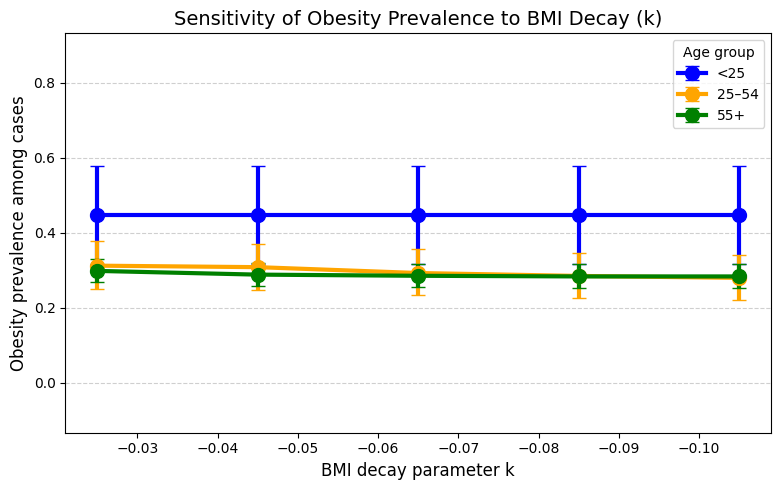

In [14]:
# Sensitivity analysis k values and corresponding CSV files
k_values = [-0.025, -0.045, -0.065, -0.085, -0.105]
files = [
    "k1results.csv",
    "k2results.csv",
    "k3results.csv",
    "k4results.csv",
    "k5results.csv"
]

# Row indices for obesity prevalence by age group
age_rows = [10, 11, 12]
age_labels = ["<25", "25–54", "55+"]

colors = ["blue", "orange", "green"]

# Reverse order so plot runs from weak → strong decay
k_values = k_values[::-1]
files = files[::-1]

# Store results: rows = age groups, columns = k values
means = np.zeros((3, len(k_values)))
lower = np.zeros((3, len(k_values)))
upper = np.zeros((3, len(k_values)))

# Read data
for j, file in enumerate(files):
    df = pd.read_csv(file)
    for i, row in enumerate(age_rows):
        means[i, j] = df.iloc[row]["mean"]
        lower[i, j] = df.iloc[row]["lower"]
        upper[i, j] = df.iloc[row]["upper"]

plt.figure(figsize=(8, 5))

# Plot one line per age group
for i, (label, color) in enumerate(zip(age_labels, colors)):
    y = means[i]
    yerr = [y - lower[i], upper[i] - y]

    plt.errorbar(
        k_values,
        y,
        yerr=yerr,
        marker="o",
        markersize=10,
        linewidth=3,
        capsize=5,
        color=color,
        label=label
    )

plt.xlabel("BMI decay parameter k", fontsize=12)
plt.ylabel("Obesity prevalence among cases", fontsize=12)
plt.title("Sensitivity of Obesity Prevalence to BMI Decay (k)", fontsize=14)

plt.grid(axis="y", linestyle="--", alpha=0.6)
plt.legend(title="Age group")
plt.tight_layout()

# Optional: make interpretation clearer (stronger decay → right)
plt.gca().invert_xaxis()


# Widen y-axis slightly for visual clarity
y_min = lower.min()
y_max = upper.max()
padding = 1 * (y_max - y_min)  # 100% padding

plt.ylim(y_min - padding, y_max + padding)
plt.savefig("k_sensitivity_analysis.png", dpi=300)
plt.show()